# Understanding ElasticNet
Although lots of past studies have been conducted on factors affecting life expectancy using demographic variables, income composition and mortality rates, it was found that the effect of immunization and human development index was not taken into account. Hence, this motivates us to resolve this factor by formulating a regression model based on mixed effects model and multiple linear regression while considering data from 2014 for all countries. Here, important immunization like Hepatitis B, Polio and Diphtheria will also be considered. 

This dataset was taken from https://www.kaggle.com/kumarajarshi/life-expectancy-who.

First, we import packages and clean up the obtained dataset. We consider the `Life Expectancy` variable as the dependant variable whereas others are assumed to be independent variables.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("life.csv", index_col=0)
print(df.shape)
df = df.loc[df['Year']==2014, :]
df = df.drop('Year', axis=1)
df = pd.get_dummies(df, columns=['Status'])
df = df.dropna()
print(df.shape)

(2938, 21)
(131, 21)


In [3]:
df.head()

,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,...,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling,Status_Developed,Status_Developing
Country,,,,,,,,,,,,,,,,,,,,,
Afghanistan,59.9,271.0,64,0.01,73.523582,62.0,492,18.6,86,58.0,...,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0,0,1
Albania,77.5,8.0,0,4.51,428.749067,98.0,0,57.2,1,98.0,...,98.0,0.1,4575.763787,288914.0,1.2,1.3,0.761,14.2,0,1
Algeria,75.4,11.0,21,0.01,54.237318,95.0,0,58.4,24,95.0,...,95.0,0.1,547.851700,39113313.0,6.0,5.8,0.741,14.4,0,1
Angola,51.7,348.0,67,8.33,23.965612,64.0,11699,22.7,101,68.0,...,64.0,2.0,479.312240,2692466.0,8.5,8.3,0.527,11.4,0,1
Argentina,76.2,118.0,8,7.93,847.371746,94.0,1,62.2,9,92.0,...,94.0,0.1,12245.256450,42981515.0,1.0,0.9,0.825,17.3,0,1


In [4]:
# Creating training and testing dataset
y = df.iloc[:, 0] #Life expectancy
X = df.iloc[:, 1:]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 42)

1.1 Run Linear regression on the train dataset and print the $R^2$ values measured on (a) the training dataset and (b) the test dataset.

In [5]:
regr = LinearRegression().fit(X_train, y_train)
print('(a) R^2 on the training dataset:', regr.score(X_train,y_train))
print('(b) R^2 on the test dataset:', regr.score(X_test,y_test))

(a) R^2 on the training dataset: 0.8869822224758938
(b) R^2 on the test dataset: 0.8355055233744739


1.2 Run linear regression using Lasso and determine the value of $\alpha$ that results in best test set performance. Consider `alphas=10**np.linspace(1,-2,100)*0.5`. Display the best value of $\alpha$ as well as the corresponsing $R^2$ score on test set. Use the following parameters in Lasso model. Finally, store the best model separately. Also, use the co-efficients obtained and select the [columns with non-zero weights](https://stackoverflow.com/questions/62323713/selecting-columns-of-dataframe-where-lasso-coefficient-is-nonzero) and use them to create `X_train_lasso` and `X_test_lasso`. Show how many non-zero columns are present.

    copy_X=True
    normalize=True # Normalizes data using StandardScaler()
    random_state=42

In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold

In [7]:
lso = Lasso(copy_X=True, normalize=True, random_state=42)
alphas=10**np.linspace(1,-2,100)*0.5

lgs = GridSearchCV(lso, param_grid={'alpha':alphas}, scoring = 'r2')
lgs.fit(X_train, y_train)

best_params = lgs.best_params_
lso2 = Lasso(alpha=best_params['alpha'], copy_X=True, normalize=True, random_state = 42)
lso2.fit(X_train, y_train)

print('The best value of alpha =', best_params['alpha'])
print('R2 score =', lso2.score(X_test, y_test))

The best value of alpha = 0.046630167344161
R2 score = 0.8427843605806435


In [8]:
coef_not_0 = 0
for i,x in enumerate(list(X_train)):
    if lso2.coef_[i] != 0:
        coef_not_0 += 1
        print(x,lso2.coef_[i])

print()
print('There are', coef_not_0, 'non-zero coefficients')

Adult Mortality -0.016790023426984282
Total expenditure 0.19417757218620182
 HIV/AIDS -0.7238646585370816
Income composition of resources 34.25920718378277
Status_Developed 0.15496405364538163
Status_Developing -2.6334465867034187e-16

There are 6 non-zero coefficients


In [9]:
X_train_lasso = X_train.iloc[:,lso2.coef_!=0]
X_test_lasso = X_test.iloc[:,lso2.coef_!=0]

1.3 Run linear regression using Ridge and determine the value of $\alpha$ that results in best test set performance. Consider `alphas=10**np.linspace(1,-2,100)*0.5`. Display the best value of $\alpha$ as well as the corresponsing $R^2$ score on test set. Use the following parameters in Ridge model.

    copy_X=True
    normalize=True # Normalizes data using StandardScaler()
    random_state=42

In [10]:
from sklearn.linear_model import Ridge

rdg = Ridge(copy_X=True, normalize=True, random_state=42)
alphas=10**np.linspace(1,-2,100)*0.5

rgs = GridSearchCV(rdg, param_grid={'alpha':alphas}, scoring = 'r2')
rgs.fit(X_train, y_train)

best_params = rgs.best_params_
rdg2 = Ridge(alpha=best_params['alpha'], copy_X=True, normalize=True, random_state = 42)
rdg2.fit(X_train, y_train)

print('The best value of alpha =', best_params['alpha'])
print('R2 score =', rdg2.score(X_test, y_test))

The best value of alpha = 0.03527401155359323
R2 score = 0.8280328164651207


1.4 Run [ElasticNet](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html) [(Video Reference)](https://youtu.be/1dKRdX9bfIo) on the `X_train_lasso` dataset by using all possible values from the below mentioned parameter set:

    l1_ratios = np.arange(0, 1.01, 0.01)  # 101 elements
    alphas = 10**np.linspace(1, -2, 100)*0.5 # 100 elements
    normalize = True
    random_state = 42


Store the $R^2$ score obtained from `X_test_lasso` set for each combination in an array with 101 rows and 100 columns. e.g.

    arr[i][j] = curr_r2_score # obtained using l1_ratios[i] and alphas[j]

where `i` is the `ith` element from `l1_ratio` and `j` is the `jth` element from `alphas`. Print the best $R^2$ score obtained using test set and its corresponding `alpha` and `l1 ratio`.

In [11]:
arr = np.zeros((101, 100)) # Create 101x100 array

In [12]:
from sklearn.linear_model import ElasticNet

l1_ratios = np.arange(0, 1.01, 0.01)  # 101 elements
alphas = 10**np.linspace(1, -2, 100)*0.5 # 100 elements

Note that by varying the `l1_ratio`, you are controlling the ratio of Lasso and Ridge regularization that is present in the model. When `l1_ratio = 1`, it means that the model uses Lasso regularization only whereas when `l1_ratio = 0`, it means that the model uses Ridge regularization only. You can find the formula for the loss function [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html).

In [13]:
for i in l1_ratios:
    for j in alphas:
        enet = ElasticNet(alpha=j, l1_ratio=i ,normalize=True, random_state=42)
        enet_fit = enet.fit(X_train_lasso, y_train)
        r2_test = enet_fit.score(X_test_lasso, y_test)
        arr[np.where(l1_ratios==i),np.where(alphas==j)] = r2_test
        
print(arr)

[[-0.10134863 -0.10063589 -0.09987265 ...  0.78378853  0.78892584
   0.79375085]
 [-0.10217524 -0.10145461 -0.10068294 ...  0.7845193   0.78961364
   0.79439753]
 [-0.10301908 -0.10229039 -0.1015101  ...  0.78525172  0.79030209
   0.79504485]
 ...
 [-0.11130508 -0.11130508 -0.11130508 ...  0.8543979   0.85451802
   0.85462815]
 [-0.11130508 -0.11130508 -0.11130508 ...  0.85472379  0.85481618
   0.85490116]
 [-0.11130508 -0.11130508 -0.11130508 ...  0.85500085  0.85507108
   0.8551358 ]]


1.5 Call `plot_heatmap()` using the 101x100 array (after flipping it horizontally using [np.fliplr()](https://numpy.org/doc/stable/reference/generated/numpy.fliplr.html)) from the previous question. What does this heatmap represent? Interpret the heatmap.

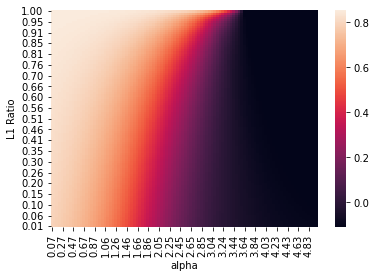

In [14]:
import seaborn as sns

def rescale(val, in_min, in_max, out_min, out_max):
    return out_min + (val - in_min) * ((out_max - out_min) / (in_max - in_min))

def format_y(value, tick_number):
    return f'{value/100.:0.2f}'

def format_x(value, tick_number):
    return f'{rescale(value, 0., 100., 0.05, 5.):0.2f}'

def plot_heatmap(arr):
    ax = sns.heatmap(arr)
    ax.set_ylabel("L1 Ratio")
    ax.set_xlabel("alpha")
    ax.invert_yaxis()
    ax.xaxis.set_major_formatter(plt.FuncFormatter(format_x))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(format_y))
    
plot_heatmap(np.fliplr(arr))

This heatmap represents the reduction of the coefficients as alpha increases, per increasing/decreasing values of L1. 

The L1 Ratio determines the mix of Lasso and Ridge regression in the elastic net - specifically, l1_ratio = 1 is the Lasso penalty and l1_ratio = 0 is the Ridge penalty. The darkest area of the graph reprsents coefficients that have been significantly reduced or eliminated.

This follows what we have learned, namely that when the L1 values are close to 1, the rate of reduction of the coefficients is much faster (relative to Ridge) as Lasso quickly seeks to eliminate features as penalty/alpha is increased.

# Bias-Variance
Suppose you learn a ridge regression based on some of the independent variables available to you, and including a few interaction terms as well. Your result is disappointing, and you believe that the model is suffering from either too much bias or too much variance. Describe briefly how you will test which alternative is more likely to be true. (there is no extra data that you can use, so “get more data” is not an option).

In order to test whether the model is suffereing from too much bias or too much variance, you could look at the distribution of the predictions of the model. If the deviation of the predictions is relatively small compared to your training set, you are likely underfitting (high bias). Otherwise, your disappointing result is likely caused by high variance (overfitting).

We want to build a model that can predict y for unknown inputs x.

* Use the below code to load the data from the file 'ps01.data'. It is organized as a dictionary, of train and test data.

In [15]:
from sklearn import linear_model as lm
from sklearn.metrics import mean_squared_error,mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

x_all = np.linspace(-2,5,101).reshape(-1,1)
all_files = np.load("q3_data.npz")
x_train, y_train, x_test, y_test = all_files['arr_0'], all_files['arr_1'], all_files['arr_2'], all_files['arr_3']

a. Fit a linear model to the training data, and report mean squared error on the test data. Plot the train and test points on the same plot, clearly denoting the training and testing points. On the same figure, plot the predictions of the linear model using x_all. All the plots must be in the same figure and be clearly labeled.

In [16]:
reg2 = LinearRegression().fit(x_train, y_train)
y_pred = reg2.predict(x_test)
mse_x = mean_squared_error(y_test, y_pred)
print('MSE on the test data:', mse_x)

MSE on the test data: 4.739110717634691


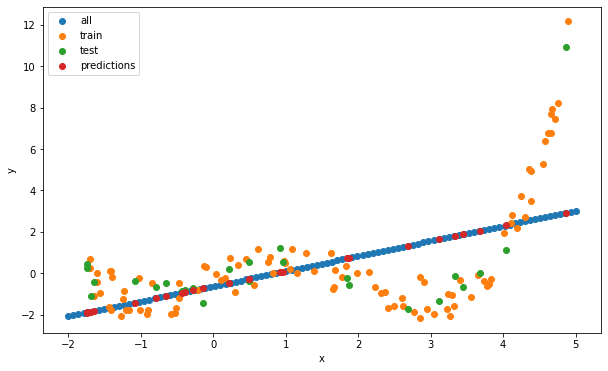

In [17]:
x_all_pred = reg2.predict(x_all)

plt.figure(figsize=(10,6))
plt.scatter(x_all, x_all_pred, label = 'all')
plt.scatter(x_train, y_train, label = 'train')
plt.scatter(x_test, y_test, label = 'test')
plt.scatter(x_test, y_pred, label = 'predictions')
plt.legend(loc = 'upper left')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

b. Fit polynomial models of degrees 2, 3, 4 and 12 to the training data, Report mean squared error (on both train and test sets) for all the models. Plot the data (train and test points) as before. On the same figure, plot the predictions of the polynomial models using x_all. All the plots must be in the same figure and be clearly labeled.

In [19]:
from sklearn.preprocessing import PolynomialFeatures

## 2nd Degree
pol2 = PolynomialFeatures(2)
pol2_x_train = pol2.fit_transform(x_train)
pol2_x_test = pol2.transform(x_test)
pol2_x_all = pol2.fit_transform(x_all)

pol2reg = LinearRegression().fit(pol2_x_train,y_train)
pol2_pred = pol2reg.predict(pol2_x_train)
mse_2_train = mean_squared_error(y_train, pol2_pred)
print('Degree 2 train MSE:\t', mse_2_train)

pol2_test_pred = pol2reg.predict(pol2_x_test)
mse_2_test = mean_squared_error(y_test, pol2_test_pred)
print('Degree 2 test MSE:\t', mse_2_test)

## 3rd Degree
pol3 = PolynomialFeatures(3)
pol3_x_train = pol3.fit_transform(x_train)
pol3_x_test = pol3.transform(x_test)
pol3_x_all = pol3.fit_transform(x_all)

pol3reg = LinearRegression().fit(pol3_x_train,y_train)
pol3_pred = pol3reg.predict(pol3_x_train)
mse_3_train = mean_squared_error(y_train, pol3_pred)
print('Degree 3 train MSE:\t', mse_3_train)

pol3_test_pred = pol3reg.predict(pol3_x_test)
mse_3_test = mean_squared_error(y_test, pol3_test_pred)
print('Degree 3 test MSE:\t', mse_3_test)

## 4th Degree
pol4= PolynomialFeatures(4)
pol4_x_train = pol4.fit_transform(x_train)
pol4_x_test = pol4.transform(x_test)
pol4_x_all = pol4.fit_transform(x_all)

pol4reg = LinearRegression().fit(pol4_x_train,y_train)
pol4_pred = pol4reg.predict(pol4_x_train)
mse_4_train = mean_squared_error(y_train, pol4_pred)
print('Degree 4 train MSE:\t', mse_4_train)

pol4_test_pred = pol4reg.predict(pol4_x_test)
mse_4_test = mean_squared_error(y_test, pol4_test_pred)
print('Degree 4 test MSE:\t', mse_4_test)

## 12th Degree
pol12= PolynomialFeatures(12)
pol12_x_train = pol12.fit_transform(x_train)
pol12_x_test = pol12.transform(x_test)
pol12_x_all = pol12.fit_transform(x_all)

pol12reg = LinearRegression().fit(pol12_x_train,y_train)
pol12_pred = pol12reg.predict(pol12_x_train)
mse_12_train = mean_squared_error(y_train, pol12_pred)
print('Degree 12 train MSE:\t', mse_12_train)

pol12_test_pred = pol12reg.predict(pol12_x_test)
mse_12_test = mean_squared_error(y_test, pol12_test_pred)
print('Degree 12 test MSE:\t', mse_12_test)

Degree 2 train MSE:	 3.241421853814466
Degree 2 test MSE:	 3.118688012803552
Degree 3 train MSE:	 1.4201223351315244
Degree 3 test MSE:	 1.6698703639509385
Degree 4 train MSE:	 0.3745950147780313
Degree 4 test MSE:	 0.27939743902348957
Degree 12 train MSE:	 0.32974847922700123
Degree 12 test MSE:	 0.40228761974839355


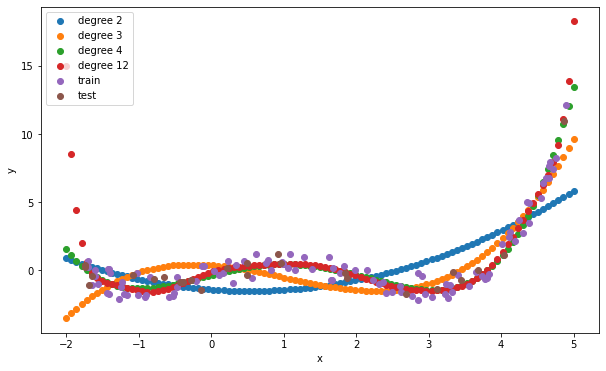

In [20]:
plt.figure(figsize=(10,6))
plt.scatter(x_all, pol2reg.predict(pol2_x_all), label = 'degree 2')
plt.scatter(x_all, pol3reg.predict(pol3_x_all), label = 'degree 3')
plt.scatter(x_all, pol4reg.predict(pol4_x_all), label = 'degree 4')
plt.scatter(x_all, pol12reg.predict(pol12_x_all), label = 'degree 12')
plt.scatter(x_train, y_train, label = 'train')
plt.scatter(x_test, y_test, label = 'test')
plt.legend(loc = 'upper left')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

c. Which model performed the best? Explain.

The 4th degree polynomial model performed the best. This is intuitive - judging from the plots in parts a and b - as the relationship between x and y more closely follows the natural shape of a 4th order polynomial. Fitting the polynomial to this data provides a clear advantage over linear regression, and measuring across polynomials of different orders allows us to identify the most appropriate fit to use when prediciting on our inputs.

# Stochastic Gradient Descent

In [23]:
%matplotlib inline
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

class Regression:
    
    def __init__(self, learning_rate, regularization, n_epoch):
        self.learning_rate = learning_rate
        self.n_epoch = n_epoch
        self.regularization = regularization
        self.coef = np.array([0,0,0,0])
        
    def sgd(self, gradient):
        self.coef = self.coef - self.learning_rate*gradient
        
    def fit(self, X, y, update_rule='sgd', plot=False):
        mse = []
        coefs = []
        self.cache = np.zeros(self.coef.shape)
        self.v = np.zeros(self.coef.shape)
        self.decay_rate = 0.9
        X = self.get_features(X)
        for epoch in range(self.n_epoch):
            for i in range(X.shape[0]):
              
                error = (y[i] - np.dot(np.transpose(self.coef), X[i]))
                       
                gradient = -np.dot(error,X[i].T)
                
                self.sgd(gradient)
            coefs.append(self.coef)
            residuals = y - np.dot(np.transpose(self.coef), X[i])         
            mse.append(np.mean(residuals**2))
        self.lowest_mse = min(mse)
        if self.lowest_mse <1 and self.lowest_mse > 0:
            print(self.lowest_mse)
            if plot == True:
                plt.figure()
                plt.plot(range(self.n_epoch),mse)
                plt.xlabel('epoch')
                plt.ylabel('MSE')
                plt.figure()
                coefs = np.array(coefs)
                plt.plot(range(self.n_epoch),coefs[:,0],label='w0')
                plt.plot(range(self.n_epoch),coefs[:,1],label='w1')
                plt.plot(range(self.n_epoch),coefs[:,2],label='w2')
                plt.plot(range(self.n_epoch),coefs[:,3],label='w3')
                plt.xlabel('epoch')
                plt.ylabel('parameter value')
                
    def get_features(self, X):
        '''
        this output of this function can be used to compute the gradient in `fit`
        '''
        x = np.zeros((X.shape[0], 4))
        x[:,0] = 1
        x[:,1] = X[:,0]
        x[:,2] = X[:,0]*X[:,1]
        x[:,3] = np.exp(-X[:,0])
        return x
    
    def linearPredict(self, X):  
        self.linearPredict = np.dot(np.transpose(self.coef),X) 

In [24]:
data = pd.read_csv('q4_samples.csv')
X = np.array([data['x1'].values, data['x2'].values]).T
y = data['y'].values
n_epochs = 15
learning_rate = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
regularization = [0, 10, 100]

1. Using stochastic gradient descent, derive the coefficent updates for all 4 coefficients of the model: $$ y = w_0 + w_1x_1 + w_2x_1x_2 + w_3e^{-x_1} $$ Hint: start from the cost function (Assume sum of squared error). If you write the math by hand, include the image in your notebook and upload the image in the submission.

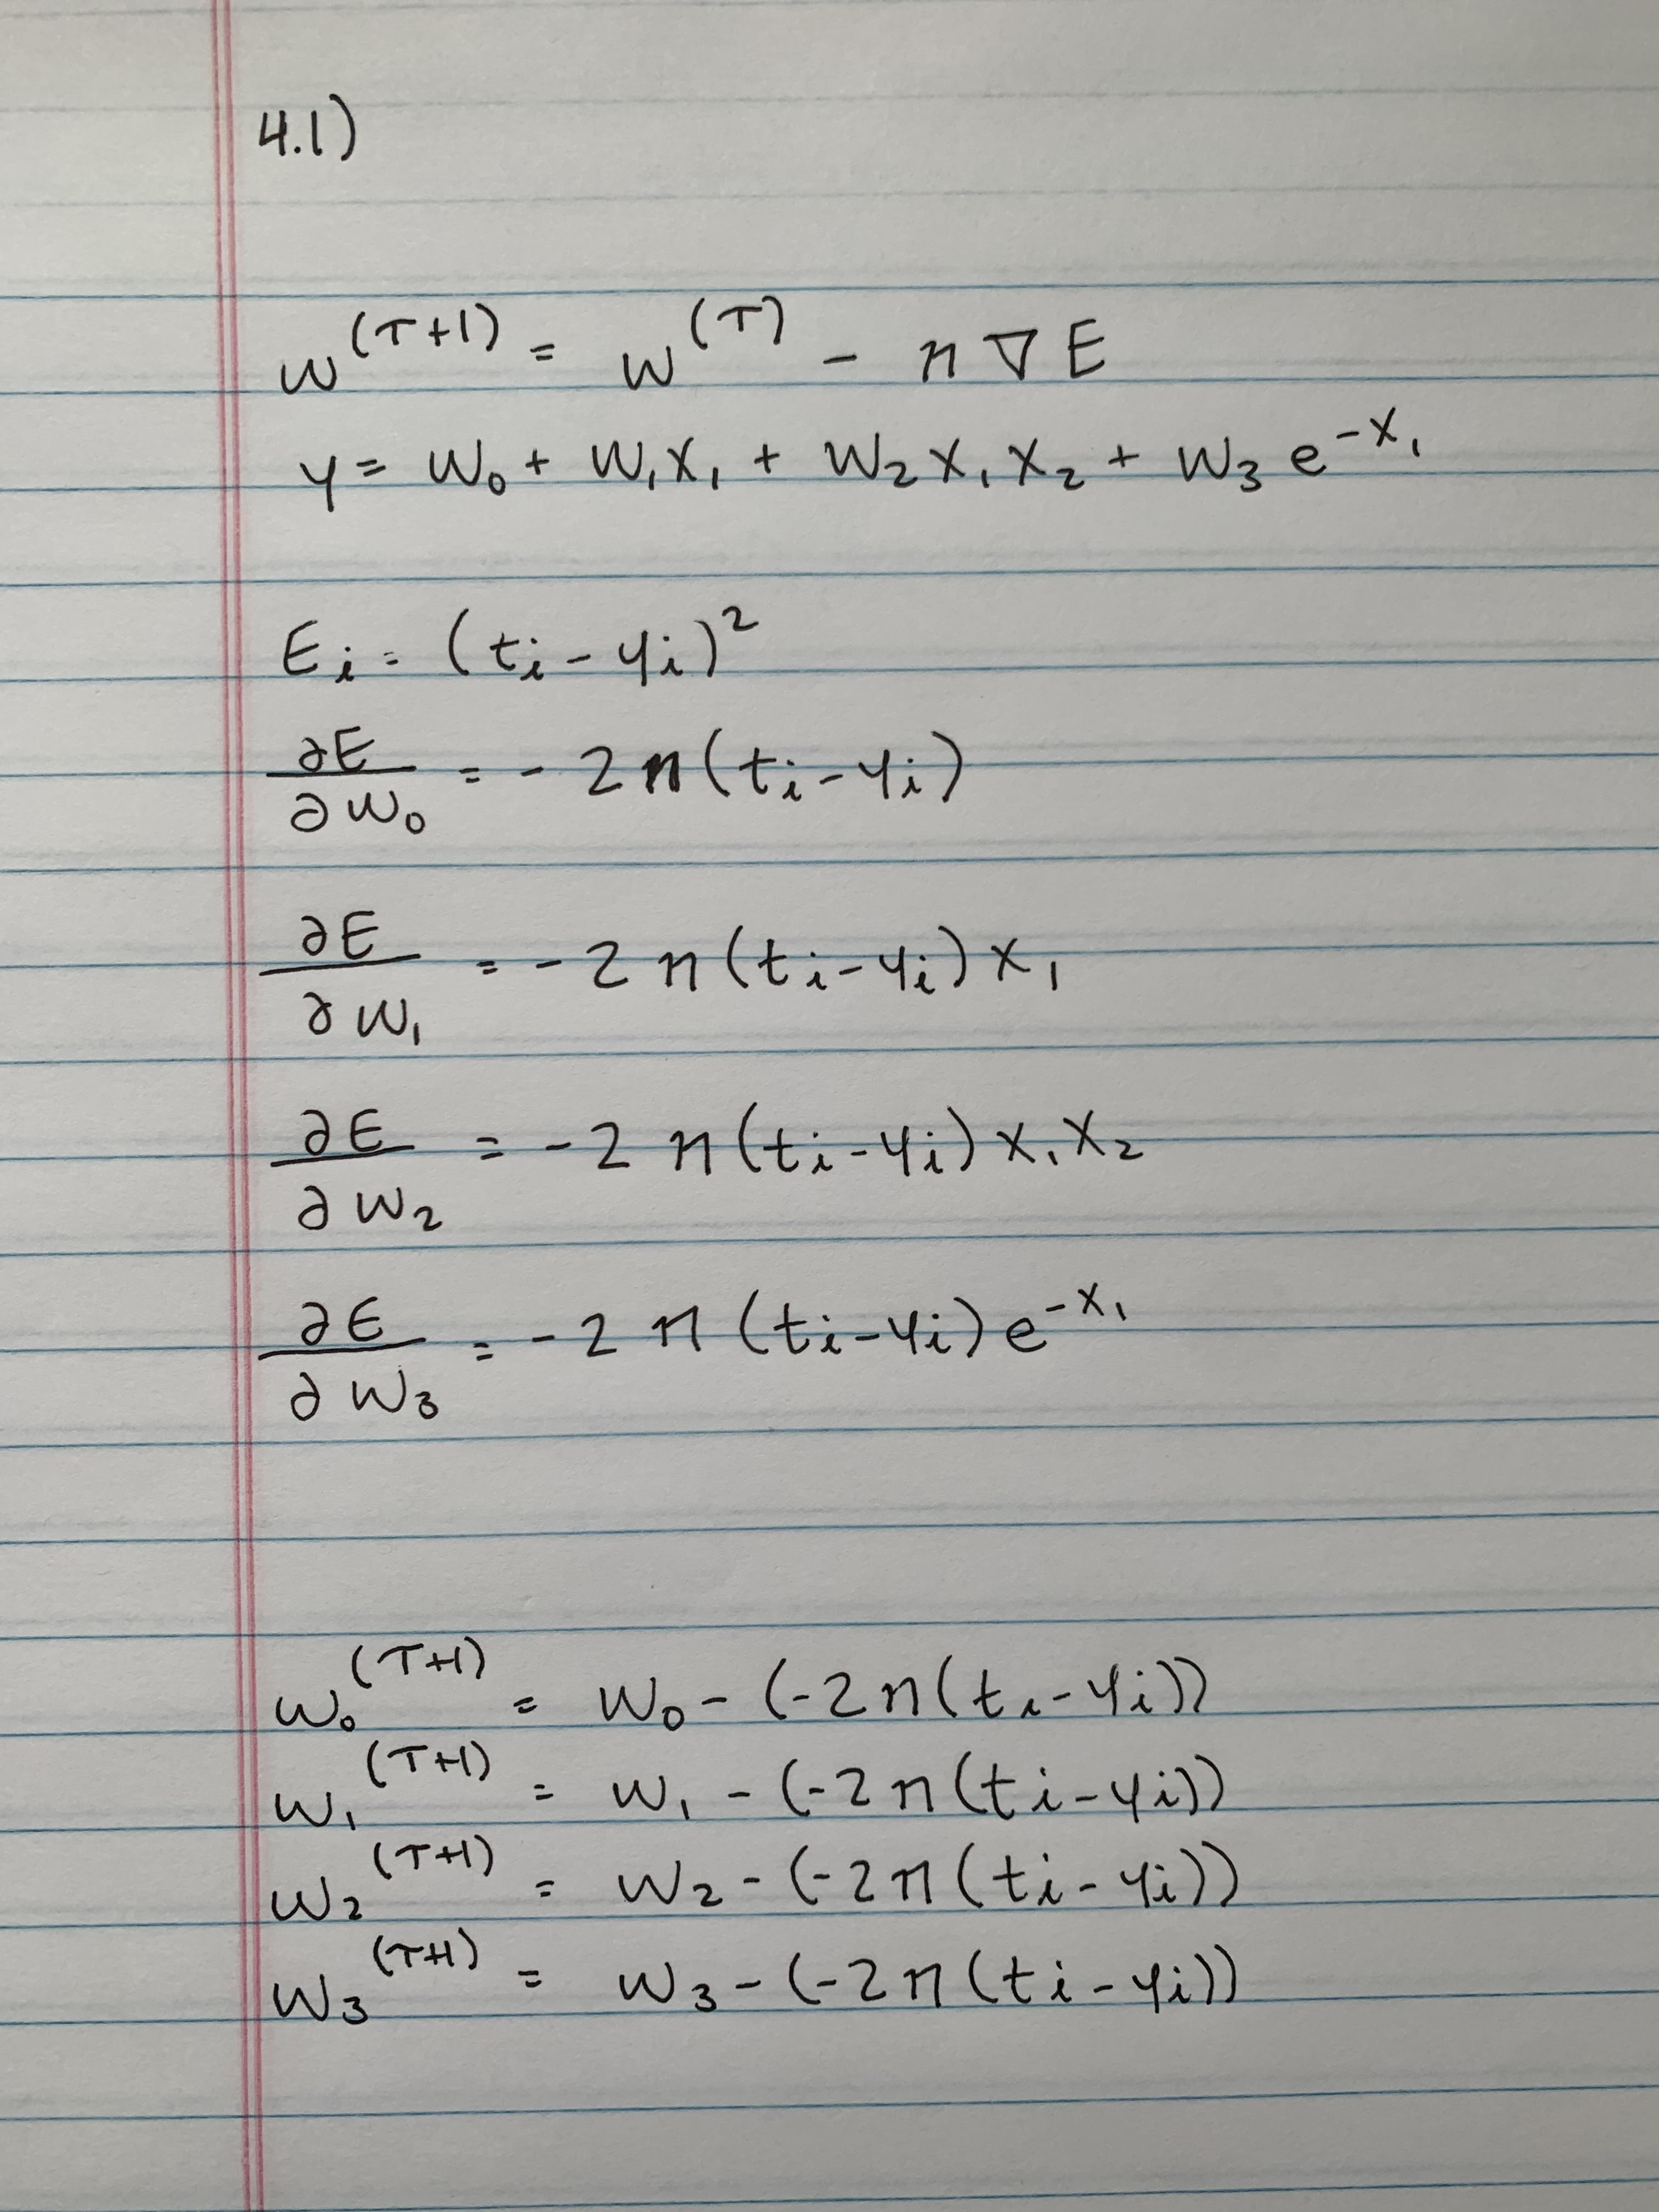

2. Write Python code for an SGD solution to the non-linear model$$ y = w_0 + w_1x_1 + w_2x_1x_2 + w_3e^{-x_1} $$  Try to format similarly to scikit-learn's models. The template of the class is given. The init function of the class takes as input the learning_rate, regularization_constant and number of epochs. The fit method must take as input X,y. The _predict_ method takes an X value (optionally, an array of values). Use your new gradient descent regression to predict the data given in 'samples.csv', for 15 epochs, using learning rates: [0, .0001, .001, .01, 0.1, 1, 10, 100] and regularization (ridge regression) constants: [0,10,100] . Plot MSE and the $w$ parameters as a function of epoch (for 15 epochs) for the best 2 combinations of learning_rate and regularization for SGD. (2pts) Report the MSE at the end of 15 epochs for the two best combinations.

0.03695284487516172
0.03695284487516172
0.03695284487516172
0.03379675906552215
0.03379675906552215
0.03379675906552215
0.03379569660014576
0.03379569660014576
0.03379569660014576
0.0370949067411122
0.0370949067411122
0.0370949067411122


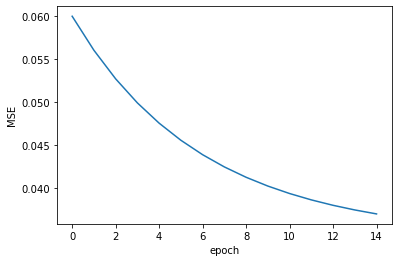

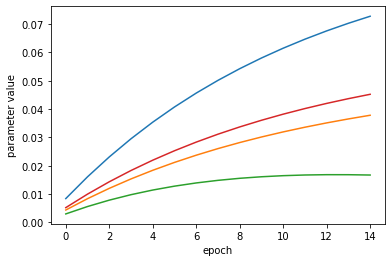

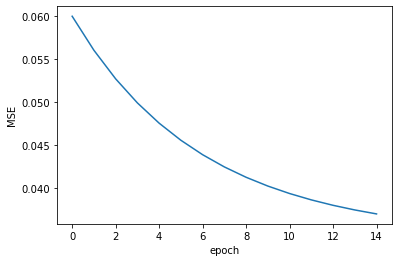

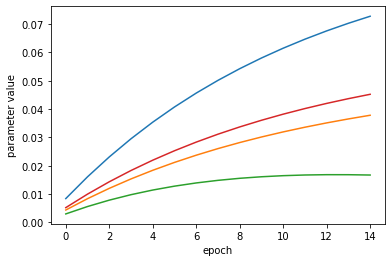

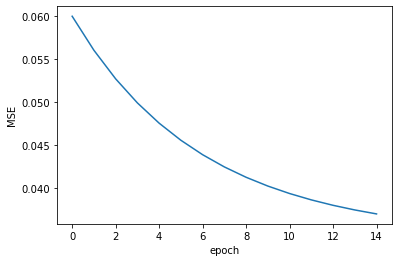

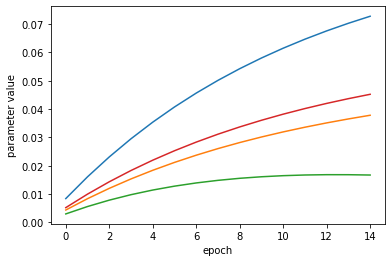

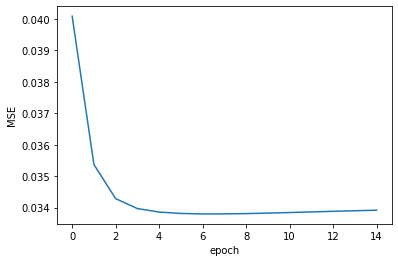

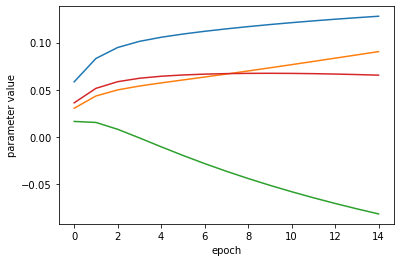

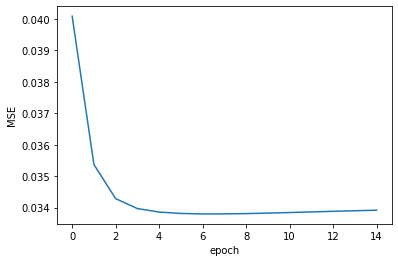

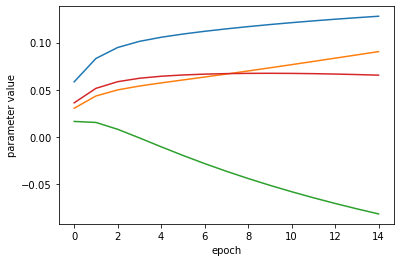

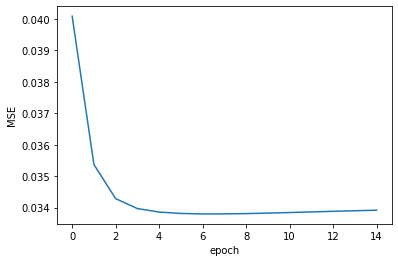

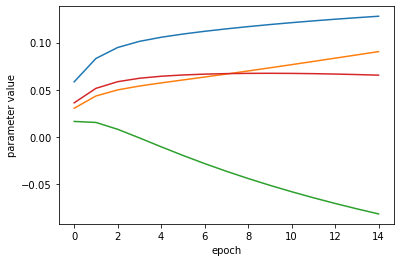

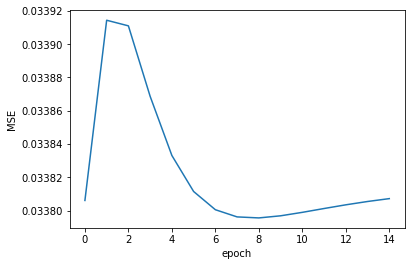

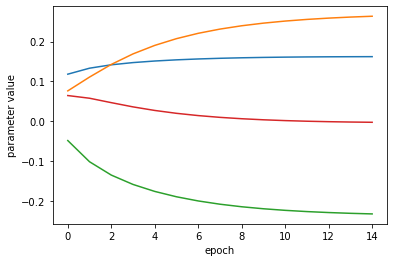

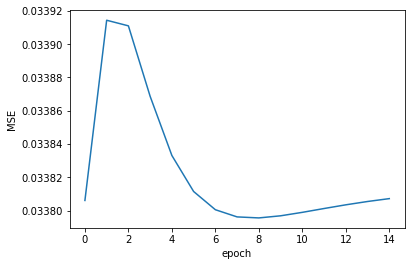

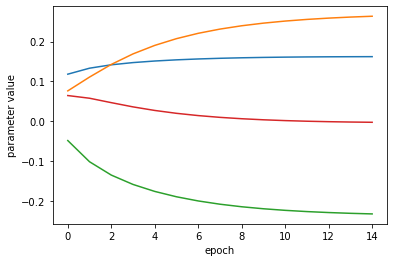

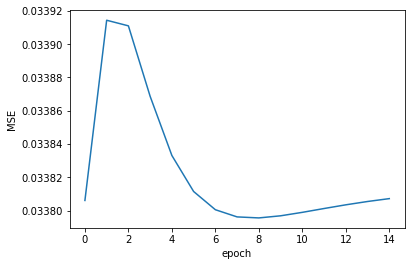

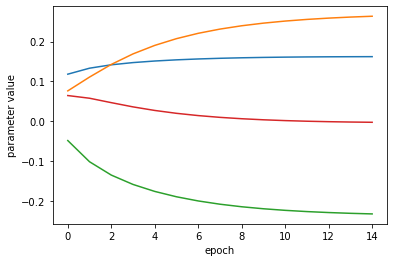

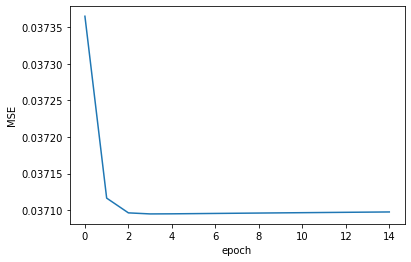

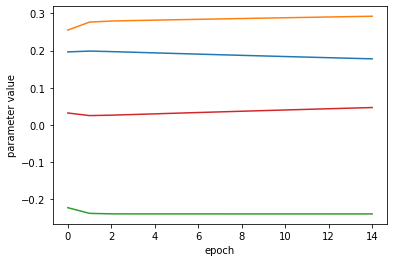

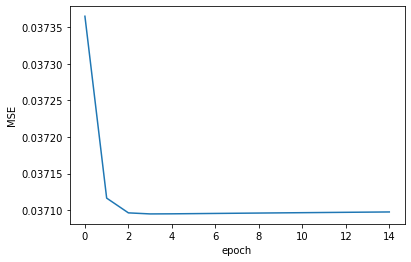

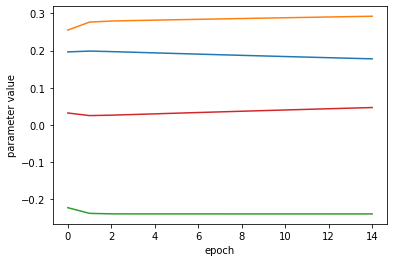

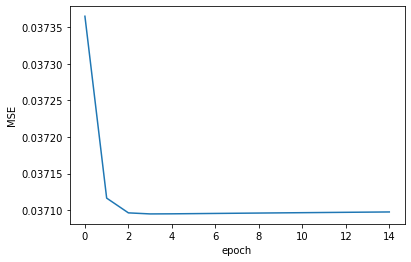

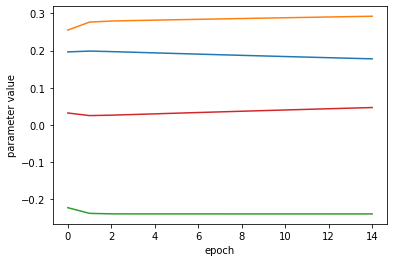

In [25]:
for l in learning_rate:    
    for r in regularization:
        model = Regression(learning_rate=l, regularization=r, n_epoch=n_epochs)
        model.fit(X,y, update_rule='sgd',plot=True)

0.03379569660014576


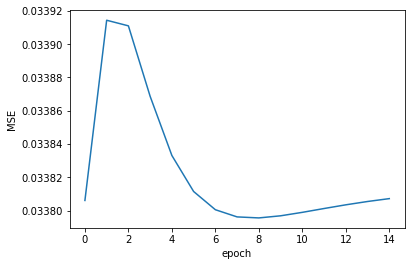

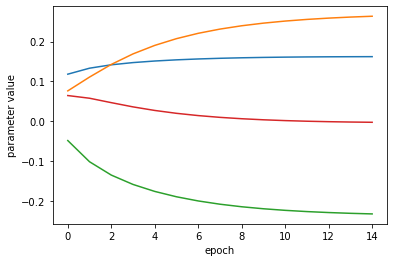

In [26]:
model = Regression(learning_rate=0.01, regularization=0, n_epoch=n_epochs)
model.fit(X,y, update_rule='sgd',plot=True)

0.03379569660014576


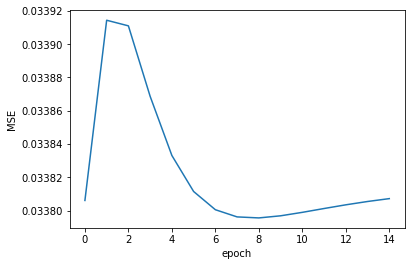

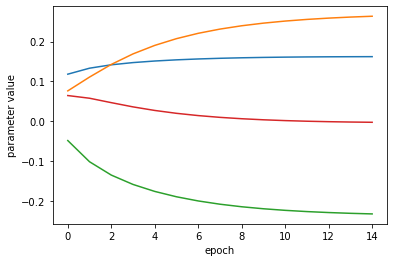

In [27]:
model = Regression(learning_rate=0.01, regularization=10, n_epoch=n_epochs)
model.fit(X,y, update_rule='sgd',plot=True)